<a href="https://colab.research.google.com/github/0ethel0zhang/quantcon2022/blob/main/IMDB_Movie_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credits

You can refer to [this TensorFlow tutorial](https://www.tensorflow.org/hub/tutorials/tf2_text_classification) for how to import the data.

# 0. Setup

## Import Libraries

In [1]:
import numpy as np
import pandas as

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


## Download the IMDB dataset

The IMDB dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [2]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


## Explore the data 

In [3]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


Let's create a small sample of 1000 reviews.

In [28]:
sample_n = 100 #@param sample_n
sample = train_examples[:sample_n] 
sample[:3]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

# 1. Build the model

Building a clustering model requires three main architectural decisions:

* How to represent the text?
* Which clustering model to use?

## 1.1 Transform input

In this example, the input data consists of sentences. As suggested by TensorFlow, "One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning.
"


Here are many [embeddings models](https://www.tensorflow.org/text/guide/word_embeddings) from [TensorFlow Hub](https://www.tensorflow.org/hub) that you can try. This turorial will use the Universal Language Encoder i.e. **Option 1** in the following list of light-weight embeddings:

* [universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder/4) "*The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.*"
* [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2) - 50-dimension embedding trained on English Google News 7B corpus
* [google/nnlm-en-dim50-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2) - same as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with additional text normalization to remove punctuation. This can help to get better coverage of in-vocabulary embeddings for tokens on your input text.
* [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - A larger model with an embedding dimension of 128 instead of  50.

In [7]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [6]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  # g.set_xticklabels(labels, rotation=rotation)
  g.set_yticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

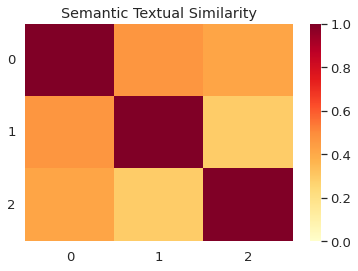

In [56]:
plot_similarity(range(3), embed(sample[:3]), 0)

In [29]:
embeddings = embed(sample)

## 1.2 Build clustering model

Since text clusters are rarely of similar sizes and most of the time, we don't know the exact number of clusters there are, this tutorial focuses on clustering methodologies that deals with non-spherical data and do not require pre-determined number of clusters. Usually hierarchical clustering models are more suitable for these needs. One such model that we will cover in this tutorial is the AgglomerativeClustering model in sklearn.

In [12]:
def cluster_with_cosine_way(embeddings, way = 'complete'):
  linkage_df = sch.linkage(embeddings, method = way, metric = "cosine")
  threshold = 0.7*max(linkage_df[:,2])
  ncluster = sum([x[2] > threshold for x in linkage_df]) + 1
  # create clusters
  hc = AgglomerativeClustering(
      n_clusters = ncluster, affinity = 'cosine', linkage = way)
  # save clusters for chart
  y_hc = hc.fit_predict(embeddings)
  return y_hc

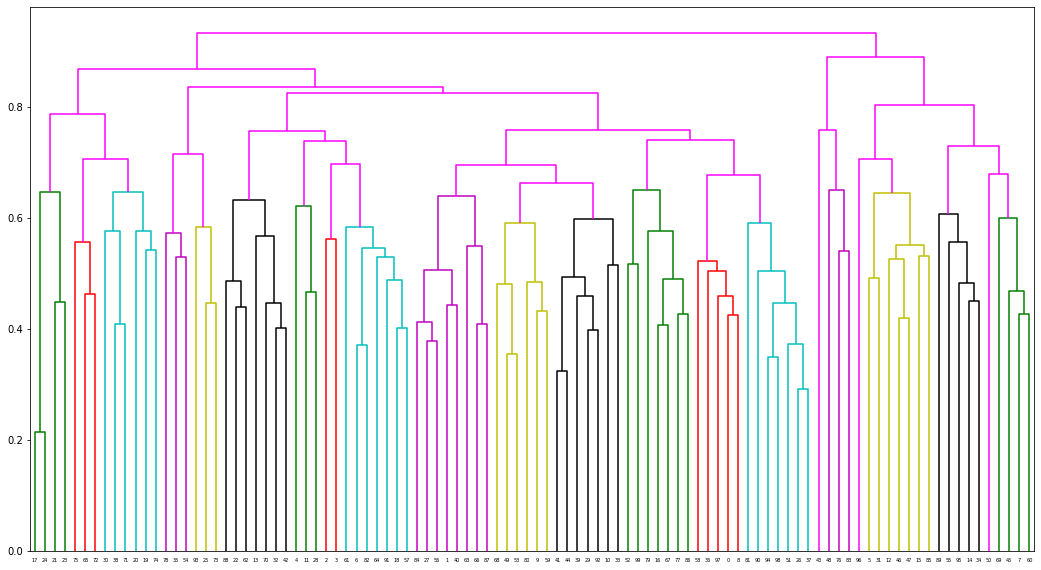

In [35]:
#@title Create dendrogram graph
plt.figure(figsize = (18, 10))
dendrogram = sch.dendrogram(
    sch.linkage(embeddings, method='complete', metric = "cosine"), 
    leaf_rotation=0, above_threshold_color='magenta')
plt.hlines(1.25, 0, 1000, color = "magenta")

In [36]:
y_hc = cluster_with_cosine_way(embeddings, "complete")

In [37]:
output_df = pd.DataFrame([y_hc, sample]).T.rename(columns = dict(zip(range(2), ["cluster", "review"])))

## 1.3 Explore output

In [38]:
output_df.cluster.value_counts()

8     8
0     7
7     7
4     7
9     7
12    7
10    7
2     6
21    6
6     5
20    5
11    4
3     4
5     3
13    3
14    3
1     3
15    3
18    2
17    1
19    1
16    1
Name: cluster, dtype: int64

In [45]:
output_df.sort_values("cluster").head()

,cluster,review
99,0,b'My family has watched Arthur Bach stumble an...
52,0,b'I just saw the movie on tv. I really enjoyed...
67,0,b'I absolutely fail to see what is funny in th...
77,0,"b'In an era of such awful cartoons, I am rathe..."
79,0,"b""I have read over 100 of the Nancy Drew books..."


In [42]:
# cluster averages
cluster_label_list = output_df.cluster.unique()
cluster_idx = output_df.reset_index().groupby("cluster")["index"].unique()

cluster_centers = {}
cluster_grouped = {}
for c in cluster_label_list:
  total_embeddings = [embeddings[i,:] for i in cluster_idx[c]]
  cluster_ctr = np.mean(total_embeddings, 0)
  cluster_centers[c] = cluster_ctr
  cluster_grouped[c] = total_embeddings

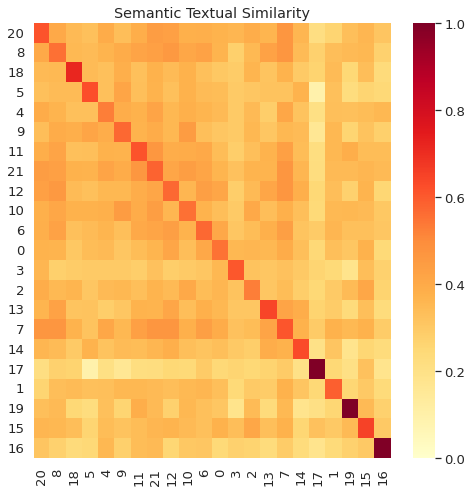

In [52]:
plt.figure(figsize = (8,8))
plot_similarity(
    list(cluster_centers.keys()), list(cluster_centers.values()), 0)